<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/5.%20Random%20Forest/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%E2%84%968.%20Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## 2. Импортируем датасет

In [78]:
df = pd.read_csv(r'../data/titanic/train.csv')

## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [79]:
df.shape

(891, 12)

Просмотр 5 первых строк набора данных

In [80]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Просмотр сводной информации о наборе данных

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Частотное распределение значений признаков

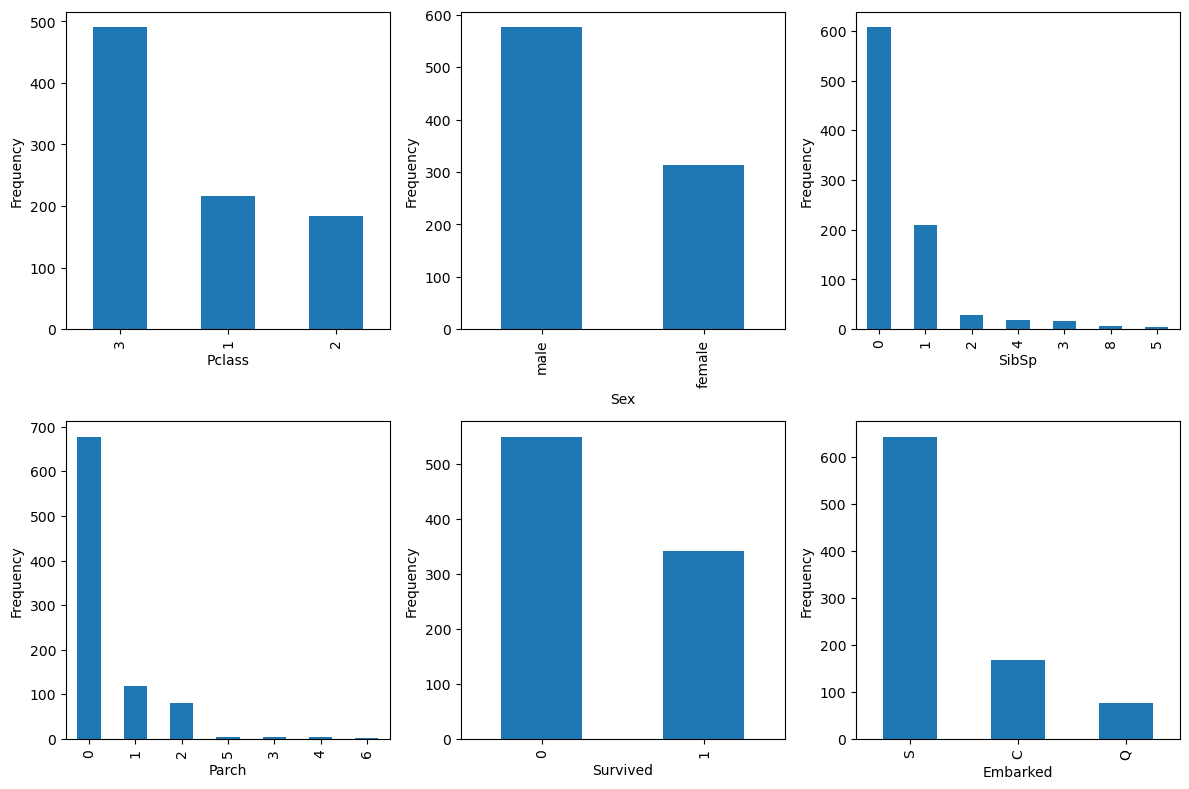

In [82]:
import matplotlib.pyplot as plt

col_names = ["Pclass", "Sex", "SibSp", "Parch", "Survived", "Embarked"]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, col in enumerate(col_names):
    ax = axs[i // 3, i % 3]
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [83]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [84]:
df = df[df["Age"].notna() & df["Embarked"].notna()]

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


## 4. Сформируем обучающую и тестовую выборки:


In [86]:
from sklearn.model_selection import train_test_split

y = df['Survived']
X = df.drop(['Survived'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [87]:
import category_encoders as ce

In [88]:
encoder = ce.OrdinalEncoder(cols=['Sex', 'Embarked'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

Оставим только числовые параметры

In [89]:
X_train = X_train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]

In [90]:
X_test = X_test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]

In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 472 to 131
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    569 non-null    int64  
 1   Sex       569 non-null    int32  
 2   Age       569 non-null    float64
 3   SibSp     569 non-null    int64  
 4   Parch     569 non-null    int64  
 5   Fare      569 non-null    float64
 6   Embarked  569 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 31.1 KB


In [92]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
641,1,1,24.0,0,0,69.3000,2
496,1,1,54.0,1,0,78.2667,2
262,1,2,52.0,1,1,79.6500,1
311,1,1,18.0,2,2,262.3750,2
551,2,2,27.0,0,0,26.0000,1


## 6. Построение базовой модели:

In [93]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=0)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [94]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def get_accuracy_report(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    report = classification_report(y_test, y_pred)
    print(report)

### 7.2. Оцените точность модели:

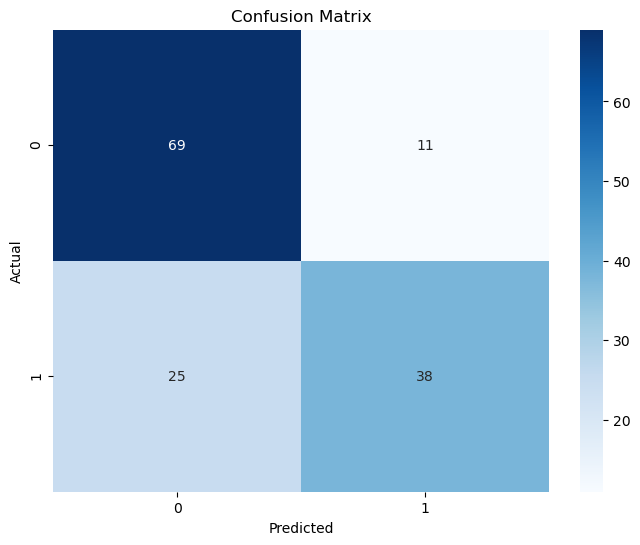

              precision    recall  f1-score   support

           0       0.73      0.86      0.79        80
           1       0.78      0.60      0.68        63

    accuracy                           0.75       143
   macro avg       0.75      0.73      0.74       143
weighted avg       0.75      0.75      0.74       143



In [95]:
get_accuracy_report(y_pred, y_test)

## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=10)]
max_depth = [int(x) for x in np.linspace(10, 500, num=5)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(2, 100)]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

rf_clf = RandomForestClassifier(random_state=0)

rf_cv = RandomizedSearchCV(
    estimator=rf_clf,
    scoring='accuracy',
    param_distributions=random_grid,
    n_iter=300,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)

rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

y_pred_rs = rf_clf.predict(X_test)
print('Оценка точности модели при подборе параметров с помощью RandomizedSearchCV : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Best paramters: {'n_estimators': 100, 'max_leaf_nodes': 33, 'max_depth': 500})
Оценка точности модели при подборе параметров с помощью RandomizedSearchCV : 0.7972


GridSearchCV

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

n_estimators = [int(i) for i in range(180, 200)]
max_depth = [500]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(70, 100)]

params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

rf_clf = RandomForestClassifier(random_state=0)

rf_cv = GridSearchCV(
    rf_clf,
    params_grid,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)


rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
print('Оценка точности модели при подборе параметров с помощью GridSearchCV : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Best parameters: {'max_depth': 500, 'max_leaf_nodes': 77, 'n_estimators': 192}
Оценка точности модели при подборе параметров с помощью GridSearchCV : 0.7972


## 9. Оценка лучшей модели:

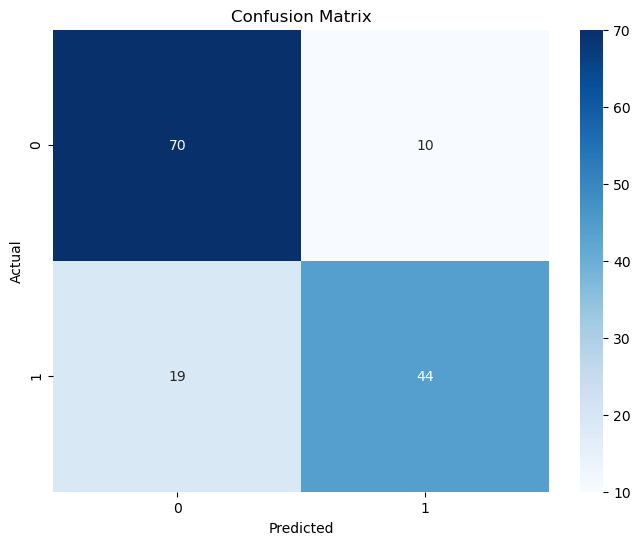

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        80
           1       0.81      0.70      0.75        63

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.79       143



In [101]:
get_accuracy_report(y_pred, y_test)

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [103]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier


tree_classifier = DecisionTreeClassifier(random_state=13)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 13, 21],
    'min_samples_leaf': [2, 5, 13, 21],
}

grid = GridSearchCV(tree_classifier, param_grid, cv=5, verbose=1)

grid_search = grid.fit(X_train, y_train)

best_params = grid.best_params_
print(f"Best parameters: {best_params}")

tree = DecisionTreeClassifier(**best_params)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
print('Оценка точности модели при подборе параметров с помощью GridSearchCV : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}
Оценка точности модели при подборе параметров с помощью GridSearchCV : 0.7622


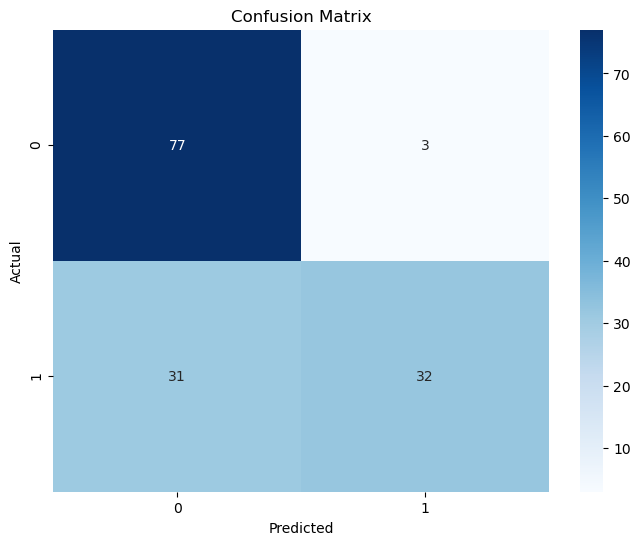

              precision    recall  f1-score   support

           0       0.71      0.96      0.82        80
           1       0.91      0.51      0.65        63

    accuracy                           0.76       143
   macro avg       0.81      0.74      0.74       143
weighted avg       0.80      0.76      0.75       143



In [104]:
get_accuracy_report(y_pred, y_test)

In [107]:
# KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [1, 2, 3, 5, 10, 20, 50, 100, 150, 200],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}

grid = GridSearchCV(knn, param_grid, cv=10, scoring='r2', verbose=1)

grid_search = grid.fit(X_train, y_train)

best_params = grid.best_params_
print(f"Best parameters: {best_params}")

knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('Оценка точности модели при подборе параметров с помощью GridSearchCV : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'}
Оценка точности модели при подборе параметров с помощью GridSearchCV : 0.6573


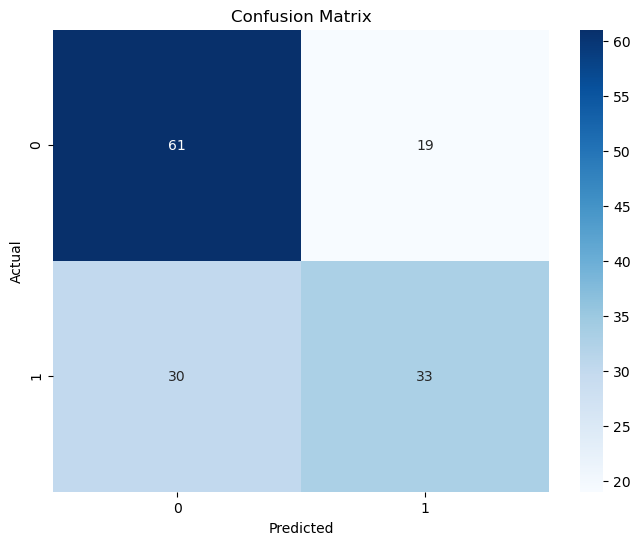

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        80
           1       0.63      0.52      0.57        63

    accuracy                           0.66       143
   macro avg       0.65      0.64      0.64       143
weighted avg       0.65      0.66      0.65       143



In [108]:
get_accuracy_report(y_pred, y_test)

# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

Создадим нашу модель

In [110]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=10)]
max_depth = [int(x) for x in np.linspace(10, 500, num=5)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(2, 100)]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

rf_clf = RandomForestClassifier(random_state=0)

rf_cv = RandomizedSearchCV(
    estimator=rf_clf,
    scoring='accuracy',
    param_distributions=random_grid,
    n_iter=300,
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)

rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

Best paramters: {'n_estimators': 100, 'max_leaf_nodes': 33, 'max_depth': 500})


In [129]:
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int64)

In [123]:
X_train['Fare'].max()

512.3292

In [134]:
import pyinputplus as pyip


def predict_person(model):
    data = pd.DataFrame({
        "Pclass": [pyip.inputInt(prompt="Enter the Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd):\n", min=X_train['Pclass'].min(), max=X_train['Pclass'].max())],
        "Sex": [pyip.inputInt(prompt="Enter Sex (1 = Male, 2 = Female):\n", min=X_train['Sex'].min(), max=X_train['Sex'].max())],
        "Age": [pyip.inputFloat(prompt="Enter Age:\n", max=120)],
        "SibSp": [pyip.inputInt(prompt="Enter the number of siblings / spouses:\n", max=10)],
        "Parch": [pyip.inputInt(prompt="Enter the number of parents / children:\n", max=10)],
        "Fare": [pyip.inputInt(prompt="Passenger fare:\n", max=1000)],
        "Embarked": [pyip.inputInt(prompt="Port of Embarkation (Southampton = 1, Cherbourg = 2, Queenstown = 3):\n", min=X_train['Embarked'].min(), max=X_train['Embarked'].max())],
    })
    y_pred = model.predict(data)
    print(
        f"This Passanger is probably {'dead' if y_pred[0] == 0 else 'alive'}")

In [135]:
predict_person(rf_clf)

Enter the Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd):
Enter Sex (1 = Male, 2 = Female):
Enter Age:
Enter the number of siblings / spouses:
Number must be at maximum 10.
Enter the number of siblings / spouses:
Enter the number of parents / children:
Passenger fare:
Port of Embarkation(Southampton = 1, Cherbourg = 2, Queenstown = 3, ):
This Passanger is probably alive


# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



In [183]:
from sklearn.datasets import load_diabetes
import pandas as pd

data = load_diabetes()
data

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [184]:
X = data.data
features = data.feature_names
y = data.target

In [185]:
df = pd.DataFrame(X, columns=features)
df['target'] = y

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [186]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size=0.2,
    shuffle=True,
    random_state=3
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [187]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=1)

n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=10)]
max_depth = [int(x) for x in np.linspace(1, 100, num=5)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(2, 100)]

param_grid = {
    "criterion": ["squared_error", "friedman_mse"],
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

rf_cv = GridSearchCV(
    rfr,
    params_grid,
    scoring="r2",
    cv=5,
    verbose=0,
    n_jobs=-1
)


grid_search = rf_cv.fit(X_train, y_train)

In [188]:
grid_search.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 500,
 'max_leaf_nodes': 73,
 'n_estimators': 198}

In [189]:
rfr = grid_search.best_estimator_
y_pred_best = rfr.predict(X_test)

In [190]:
from sklearn.metrics import mean_squared_error, r2_score

print(f'R2={r2_score(y_pred_best, y_test)}')
print(f'MSE={mean_squared_error(y_pred_best, y_test)}')

R2=-0.33205175996413394
MSE=3317.7724579718542
